<a href="https://colab.research.google.com/github/Penrose3angle/Data-Project/blob/master/Kaggle_Influencers_in_Social_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Start time: 29 May 2020 22.40
# End time: 

In [1]:
from google.colab import files
uploaded = files.upload()

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('sample_predictions.csv')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Explore the data and the problem
* Understand the data structure (sample size, features available, etc.)
* Data visualisation may further help understanding.

In [0]:
print('Train size: ', train.shape[0])
print('Test size: ', test.shape[0])
print('Submission size: ', )

Train size:  5500
Test size:  5952


In [0]:
# Explore the training set
train.head()

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_follower_count,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,166.500000,11355.000000,34463,29808,1689,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939
1,0,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,18.442971,1330.366048,39262,848,1610,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337
2,0,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,68.927835,5999.896907,3622,482,206,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333
3,0,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,2.000000,96.166667,19562,17637,278,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634
4,1,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,127.404293,2833.847943,7554,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907


* We see from the training set that the features are A's and B's attributes, where most are recognizable twitter activities such as tweets/retweets, mentions, following, and some are masked network features. 
* Note that the attributes are symmetric between A and B.
* *Each datapoint describes two individuals. Pre-computed, standardised features based on twitter activity (such as volume of interactions, number of followers, etc) is provided for each individual.* (Kaggle)
* 'Choice' is our target variable here. This column is only in the train set.  

In [0]:
# Explore hte distribution of the target variable in the train set
print(train['Choice'].value_counts())

1    2802
0    2698
Name: Choice, dtype: int64


* The 'Choice' in our train set has only two unique values, 0 and 1, where 0 means that A is *more influential* than B, and 1 means otherwise. 
* Upon inspection, the numbers of data point with each value are quite balanced.

In [0]:
# Statistical description
train.describe()

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_follower_count,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
count,5500.000000,5.500000e+03,5.500000e+03,5500.000000,5.500000e+03,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5.500000e+03,5500.000000,5500.000000,5.500000e+03,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000
mean,0.509455,6.498840e+05,1.265895e+04,5952.453273,2.666032e+03,1032.371839,6.011873,1.109924,9.090730,5267.768000,84.805209,3747.219758,6.854869e+05,12738.259818,5903.148364,2.554598e+03,997.149954,6.099658,1.106236,9.505821,5254.933636,85.024196,3745.175480
std,0.499956,2.028787e+06,4.900867e+04,17339.141191,2.916543e+04,10954.953223,9.519797,1.910104,18.311060,28946.777345,104.073204,5757.339852,2.160612e+06,50054.520874,16298.462018,2.508873e+04,9342.006880,9.729557,1.939914,19.424680,26778.820125,106.689384,5518.399590
min,0.000000,1.600000e+01,0.000000e+00,0.000000,1.005034e-01,0.100503,0.100503,0.100503,0.100503,0.000000,0.000000,0.000000,2.000000e+01,0.000000,0.000000,1.005034e-01,0.100503,0.100503,0.100503,0.100503,0.000000,0.000000,0.000000
25%,0.000000,2.663750e+03,3.220000e+02,85.000000,3.453649e+00,0.716816,0.359534,0.100503,0.632440,12.000000,14.991870,1180.805341,2.498250e+03,322.000000,75.000000,3.260473e+00,0.714556,0.356943,0.100503,0.822584,11.000000,15.176568,1206.500000
50%,1.000000,4.558900e+04,7.780000e+02,932.000000,4.876542e+01,14.029113,2.299666,0.341936,3.555194,195.000000,54.925234,2206.420734,4.402700e+04,773.000000,890.000000,4.876542e+01,14.029113,2.251398,0.341936,3.342999,190.000000,54.925234,2206.420734
75%,1.000000,3.927380e+05,2.838000e+03,6734.000000,3.498196e+02,118.704407,7.198330,1.320681,10.691878,1323.000000,109.695652,4390.379310,3.701142e+05,2838.000000,6734.000000,3.743699e+02,107.081021,6.866840,1.320681,10.600502,1323.000000,112.191489,4349.908608
max,1.000000,3.654319e+07,1.165830e+06,549144.000000,1.145219e+06,435825.874241,76.809514,16.290540,193.072418,920838.000000,1121.000000,144651.461538,3.654319e+07,664324.000000,549144.000000,1.145219e+06,435825.874241,76.809514,16.290540,193.072418,920838.000000,1861.583333,75526.083333


In [0]:
test.describe()

,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_follower_count,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
count,5.952000e+03,5952.000000,5952.000000,5.952000e+03,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000,5.952000e+03,5952.000000,5952.000000,5.952000e+03,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000
mean,7.087657e+05,15816.745128,6230.993952,2.610369e+03,999.216821,6.376236,1.138599,9.665749,5170.248488,84.492860,4223.096325,7.149865e+05,14841.442372,6117.086190,2.606966e+03,1010.544365,6.199827,1.156266,9.016867,5384.529906,88.190013,4104.448241
std,2.085302e+06,57157.375055,17367.157429,2.825216e+04,10585.986980,10.699849,1.999076,19.999954,28305.471154,98.005953,7385.943025,2.121816e+06,56158.272513,16341.230784,2.462033e+04,9170.174893,10.320966,1.978121,17.658846,27497.488106,145.716530,8042.921162
min,2.000000e+01,0.000000,0.000000,1.005034e-01,0.100503,0.100503,0.100503,0.100503,0.000000,0.000000,0.000000,1.600000e+01,0.000000,0.000000,1.005034e-01,0.100503,0.100503,0.100503,0.100503,0.000000,0.000000,0.000000
25%,3.741000e+03,337.000000,103.000000,4.124998e+00,0.933434,0.362150,0.100503,0.867285,15.000000,17.914359,1230.512781,3.638000e+03,331.000000,103.000000,4.237052e+00,0.932458,0.362150,0.100503,0.847662,15.000000,17.731521,1230.512781
50%,5.445300e+04,904.000000,1062.000000,5.513727e+01,14.161040,2.299666,0.349327,3.398350,206.000000,55.483333,2352.647334,4.402700e+04,900.000000,930.500000,4.807372e+01,13.194818,2.324112,0.354379,3.342999,188.000000,57.888000,2381.466667
75%,4.885530e+05,3256.000000,6820.000000,3.882108e+02,128.707883,6.849227,1.320681,10.746838,1637.000000,117.098039,4592.000000,4.709260e+05,3115.000000,6734.000000,3.743699e+02,106.676389,6.825165,1.337915,10.691878,1323.000000,120.195059,4544.541667
max,3.654319e+07,550744.000000,549144.000000,1.145219e+06,435825.874241,96.678732,26.873251,193.072418,920838.000000,1171.333333,254193.714286,3.654319e+07,664324.000000,549144.000000,1.145219e+06,435825.874241,96.678732,26.873251,193.072418,920838.000000,8111.750000,464349.250000


In [0]:
# Explore what the submission file should look like
submit.head()

,Id,Choice
0,1,0.315025
1,2,0.474330
2,3,0.098802
3,4,0.137932
4,5,0.523677


* So the submission file only want two columns, 'Id' and 'Choice', where the predicted 'Choice' can be any value in [0,1].

In [0]:
# Visualisation
train_a = train.iloc[:, 1:12]
train_b = train.iloc[:,12:]
train_b.columns = train_a.columns
decouple = pd.concat([train_a, train_b],axis=0)
decouple.head()

,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3
0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,166.500000,11355.000000
1,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,18.442971,1330.366048
2,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,68.927835,5999.896907
3,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,2.000000,96.166667
4,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,127.404293,2833.847943


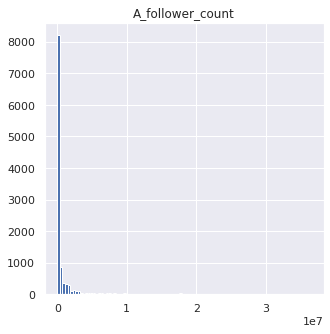

In [0]:
sns.set(rc={'figure.figsize':(5,5)})
#sns.boxplot(y='A_follower_count', data=decouple)
inv = 'A_follower_count'
decouple[inv].hist(bins=100)
plt.title(inv)
plt.show()

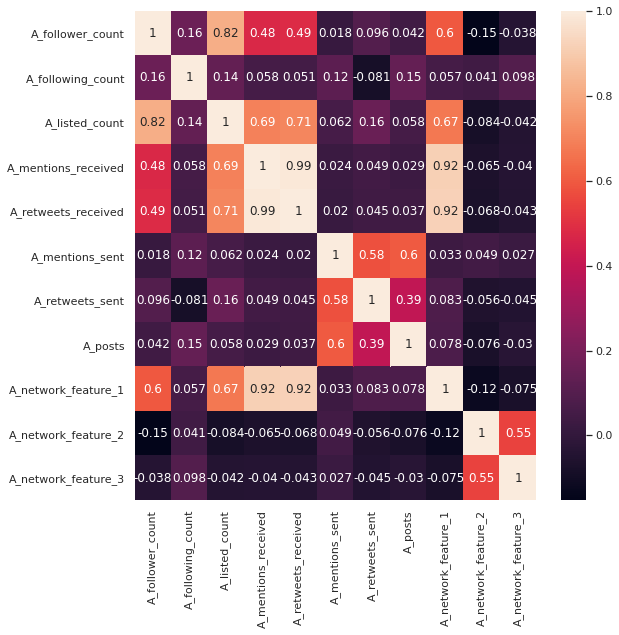

In [0]:
# Exploring correlation amongst features
sns.set(rc={'figure.figsize':(9,9)})
nw_feat = decouple[['A_network_feature_1',	'A_network_feature_2',	'A_network_feature_3']]
corr = decouple.corr()
#sns.pairplot(nw_feat)
sns.heatmap(corr, annot=True)
plt.show()

* **'mentions_received', 'retweets_received', and 'network_feature_1'** are strongly correlated. It would be better to choose just one of these features, otherwise the model performance will suffer from multicolinearity. 

# Preprocessing

In [0]:
# Check for missing values
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())

0
0


* Fortunately, we do not have any missing values in both sets. 
* (Otherwise, we would need to think about how to deal with the missing values, lest some of the algorithms, e.g. linear regression, would not be able to work. Most simple ways are dropping the data point with missing values or impute the missing values. Which method is the best depends on context.)
* Outliers are expected and meaninful in this context. The social network is likely an 'Erdos-Renyi' network, i.e., only a few nodes with extremely high degree (followers), but most nodes have low degree. So, we keep the ourliers as they are. 

# Quick Benchmarking
* Use AUC of ROC as the metric
* Original features
* Simple model
* Show the score of both the train and the dev set to help prioritise what to try next. 

In [0]:
# Evaluation function from Kaggle Page - Area under curve of the ROC
# The higher the better.
from sklearn.metrics import roc_curve, auc
def scoring(true_labels, predictions):
  fpr, tpr, thresholds = roc_curve(true_labels, predictions, pos_label=1)
  auc_score = auc(fpr,tpr)
  print('AUC: ', round(auc_score,3))
  return

In [0]:
# Separate the target from the features
X = train.drop('Choice', axis=1)
y = train['Choice']

In [0]:
# Split train and dev sets
from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(X,y, test_size=0.2, random_state=42)

In [0]:
# Start with the simplest models - the performance can be used as benchmarks
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_hat = lr.predict(X_train)
y_pred = lr.predict(X_dev)
print('AUC Score from Train set: ')
scoring(y_train, y_hat)
print('AUC Score from Dev set: ')
scoring(y_dev,y_pred)

feat_imp = pd.DataFrame({'Features': X_train.columns, 'importance': lr.coef_})
feat_imp.sort_values('importance',inplace=True)
print(feat_imp)
# Too much biases - low score on both the train set and the dev set. 

AUC Score from Train set: 
AUC:  0.786
AUC Score from Dev set: 
AUC:  0.774
               Features    importance
17      B_retweets_sent -2.169624e-02
16      B_mentions_sent -3.795511e-03
20  B_network_feature_2 -1.204857e-04
4   A_retweets_received -1.667207e-05
13       B_listed_count -1.320916e-05
19  B_network_feature_1 -7.754733e-06
21  B_network_feature_3 -6.580883e-06
3   A_mentions_received -2.427592e-06
12    B_following_count -6.841089e-08
0      A_follower_count -2.435405e-08
11     B_follower_count  3.639585e-08
1     A_following_count  4.287603e-07
14  B_mentions_received  1.654577e-06
10  A_network_feature_3  4.347859e-06
8   A_network_feature_1  6.269648e-06
2        A_listed_count  1.167129e-05
15  B_retweets_received  2.318101e-05
18              B_posts  1.861388e-04
9   A_network_feature_2  3.289335e-04
7               A_posts  8.031870e-04
5       A_mentions_sent  1.954103e-03
6       A_retweets_sent  1.729889e-02


In [0]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50,max_depth=7,max_features=5)
rf.fit(X_train,y_train)
y_hat = rf.predict(X_train)
y_pred = rf.predict(X_dev)
print('AUC Score from Train set: ')
scoring(y_train, y_hat)
print('AUC Score from Dev set: ')
scoring(y_dev,y_pred)

feat_imp = pd.DataFrame({'Features': X_train.columns, 'importance': rf.feature_importances_})
feat_imp.sort_values('importance', ascending=False, inplace=True)
print(feat_imp)
# Too much variances - Wayyyyyy overfit the train set
# The score is good though. 

AUC Score from Train set: 
AUC:  0.929
AUC Score from Dev set: 
AUC:  0.869
               Features  importance
8   A_network_feature_1    0.123574
0      A_follower_count    0.111249
13       B_listed_count    0.104920
2        A_listed_count    0.102762
19  B_network_feature_1    0.083665
14  B_mentions_received    0.080416
15  B_retweets_received    0.065265
11     B_follower_count    0.060360
3   A_mentions_received    0.045067
4   A_retweets_received    0.032967
18              B_posts    0.021916
10  A_network_feature_3    0.021902
20  B_network_feature_2    0.019255
21  B_network_feature_3    0.018817
9   A_network_feature_2    0.017640
12    B_following_count    0.015901
7               A_posts    0.014955
16      B_mentions_sent    0.014865
1     A_following_count    0.014764
17      B_retweets_sent    0.012487
5       A_mentions_sent    0.010983
6       A_retweets_sent    0.006270


In [0]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=30)
xgb.fit(X_train,y_train)
y_hat = xgb.predict(X_train)
y_pred = xgb.predict(X_dev)
print('AUC Score from Train set: ')
scoring(y_train, y_hat)
print('AUC Score from Dev set: ')
scoring(y_dev,y_pred)

[18:42:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC Score from Train set: 
AUC:  0.888
AUC Score from Dev set: 
AUC:  0.863


# Feature Selection/Engineering
* We have seen that the features are symmetric attibutes of A and B. It is worth exploring whether a ratio or a difference between these attributes would improve the fit. 
* Also, we have seen taht some original features have high correlations. Dropping the redundant features may help boost our performance. 

In [0]:
# First, what really matters in a binary preference learning task is perhaps the ratio or the difference of each person's attributes.
# So, let's try creating new feature with the ratio. 
# This probably changes the performance of the LinearRegression model the most since we generate new features with non-linear operation. 
def ratio(X):
  # Create ratio of the 5 most important attributes (from random forest).t.
  X_ratio = X.copy()
  # To avoid deviding by zero
  ep = 0.0001
  imp = ['ratio_follows', 'ratio_follower_count', 'ratio_following_count', 'ratio_network_feature_1', 'ratio_listed_count','ratio_mentions_received']
  
  #Not good 'ratio_network_feature_3' 
  X_ratio['ratio_follower_count'] = X['A_follower_count']/(X['B_follower_count']+ep)
  X_ratio['ratio_following_count'] = X['A_following_count']/(X['B_following_count']+ep)
  X_ratio['ratio_follows'] = X_ratio['ratio_follower_count']/(X_ratio['ratio_following_count']+ep)

  X_ratio['ratio_network_feature_1'] = X['A_network_feature_1']/(X['B_network_feature_1']+ep)
  X_ratio['ratio_listed_count'] = X['A_listed_count']/(X['B_listed_count']+ep)
  X_ratio['ratio_mentions_received'] = X['A_mentions_received']/(X['B_mentions_received']+ep)
  #X_ratio['ratio_network_feature_3'] = X['A_network_feature_3']/(X['B_network_feature_3']+ep)
  X_ratio = X_ratio[imp]
  # Kill the redundant column
  X_ratio.drop('ratio_following_count',axis=1, inplace=True)
  return X_ratio

In [0]:
# Make sure the new features look ready to be fit. (No NaNs, No Inf, etc.)
X_ratio = ratio(X_train)
X_ratio.describe()

,ratio_follows,ratio_follower_count,ratio_network_feature_1,ratio_listed_count,ratio_mentions_received
count,4.400000e+03,4400.000000,4.400000e+03,4.400000e+03,4.400000e+03
mean,5.806205e+03,582.955057,2.127492e+06,2.620560e+05,1.595235e+03
std,2.174348e+05,9849.756598,4.962331e+07,6.486918e+06,2.994494e+04
min,4.452669e-10,0.000004,0.000000e+00,0.000000e+00,1.528373e-06
25%,5.621414e-02,0.065102,4.852318e-02,8.204292e-02,5.448368e-02
50%,9.458713e-01,0.997998,9.999000e-01,1.067873e+00,9.532725e-01
75%,1.586100e+01,16.474250,2.117645e+01,1.253950e+01,1.924684e+01
max,1.399967e+07,477138.614307,2.137180e+09,3.062200e+08,1.725949e+06


In [0]:
# Try ratio-features with 4 top important - Improving performance in lr!
lr.fit(X_ratio,y_train)
y_pred = lr.predict(ratio(X_dev))
y_hat = lr.predict(X_ratio)

print('AUC Score from Train set: ')
scoring(y_train, y_hat)
print('AUC Score from Dev set: ')
scoring(y_dev,y_pred)

AUC Score from Train set: 
AUC:  0.84
AUC Score from Dev set: 
AUC:  0.849


The improvement of the lr model from 78% to 84% shows promises in feature engineering with ratio. 

In [0]:
def ratio_rf(X):
  # Create ratio of the 4 most important attributes (from random forest). This helps improve lr's performance by 5%, but does look overfit.
  X_ratio = X.copy()
  # To avoid deviding by zero
  ep = 0.0001
  imp = ['ratio_follower_count', 'ratio_following_count', 'ratio_network_feature_1', 'ratio_listed_count']
         #'ratio_mentions_received']
  
  #Not good 'ratio_network_feature_3' 
  X_ratio['ratio_follower_count'] = X['A_follower_count']/(X['B_follower_count']+ep)
  X_ratio['ratio_following_count'] = X['A_following_count']/(X['B_following_count']+ep)
  #X_ratio['ratio_follows'] = X_ratio['ratio_follower_count']/(X_ratio['ratio_following_count']+ep)
  
  X_ratio['ratio_network_feature_1'] = X['A_network_feature_1']/(X['B_network_feature_1']+ep)
  X_ratio['ratio_listed_count'] = X['A_listed_count']/(X['B_listed_count']+ep)
  #X_ratio['ratio_mentions_received'] = X['A_mentions_received']/(X['B_mentions_received']+ep)
  #X_ratio['ratio_network_feature_3'] = X['A_network_feature_3']/(X['B_network_feature_3']+ep)
  X_ratio = X_ratio[imp]
  
  return X_ratio

In [0]:
# Try diff-features with 4 top important - Not nice, of course, it's linear. It would have done the same, but it tells us the top 4 is enough. 
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10,20,50],
    'max_depth': [3,5,7],
    'max_features': [2,3]
}
model = RandomForestRegressor()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(ratio_rf(X_train),y_train)
y_pred = grid.predict(ratio_rf(X_dev))
y_hat = grid.predict(ratio_rf(X_train))

print('AUC Score from Train set: ')
scoring(y_train, y_hat)
print('AUC Score from Dev set: ')
scoring(y_dev,y_pred)
print(grid.best_params_)


AUC Score from Train set: 
AUC:  0.879
AUC Score from Dev set: 
AUC:  0.861
{'max_depth': 5, 'max_features': 2, 'n_estimators': 50}


In [0]:
xgb.fit(ratio_rf(X_train),y_train)
y_pred = xgb.predict(ratio_rf(X_dev))
y_hat = xgb.predict(ratio_rf(X_train))

print('AUC Score from Train set: ')
scoring(y_train, y_hat)
print('AUC Score from Dev set: ')
scoring(y_dev,y_pred)

[19:44:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC Score from Train set: 
AUC:  0.874
AUC Score from Dev set: 
AUC:  0.862


# Hyperparameter Tuning
* GridSearchCV/ RandomSearchCV
* Do this after we selected the best features. 

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10,20,50],
    'max_depth': [3,5,7,11],
    'max_features': [2,3,5,11]
}
model = RandomForestRegressor()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train,y_train)
y_pred = grid.predict(X_dev)
y_hat = grid.predict(X_train)

print('AUC Score from Train set: ')
scoring(y_train, y_hat)
print('AUC Score from Dev set: ')
scoring(y_dev,y_pred)
print(grid.best_params_)

AUC Score from Train set: 
AUC:  0.93
AUC Score from Dev set: 
AUC:  0.87
{'max_depth': 7, 'max_features': 5, 'n_estimators': 50}


# Submission 
* (for benchmarking against Kaggle scoreboard)

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
# Select y_pred from the best model
best_model = rf
y_pred = best_model.predict(test)
# For crappy model without boundary
y_pred = y_pred*(y_pred>0)

In [0]:
tosubmit = pd.DataFrame({})
tosubmit['Id'] = test.index+1
tosubmit['Choice'] = y_pred
print(tosubmit.head())
print(tosubmit.describe())

   Id    Choice
0   1  0.315959
1   2  0.654496
2   3  0.036812
3   4  0.274834
4   5  0.551087
                Id       Choice
count  5952.000000  5952.000000
mean   2976.500000     0.510391
std    1718.338733     0.304598
min       1.000000     0.009170
25%    1488.750000     0.260426
50%    2976.500000     0.509370
75%    4464.250000     0.796708
max    5952.000000     0.984853


In [0]:
tosubmit.to_csv('submission.csv', index=False)

In [0]:
!kaggle competitions submit -c predict-who-is-more-influential-in-a-social-network -f submission.csv -m "Message"

100% 140k/140k [00:01<00:00, 74.8kB/s]
Successfully submitted to Influencers in Social Networks